### all imports 

In [1]:
%matplotlib inline

In [2]:
import os
import sys
from glob import glob 

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [4]:
from calendar import day_abbr

In [5]:
import holidays

In [6]:
from fbprophet import Prophet

In [7]:
from sklearn.metrics import mean_absolute_error as MAE

In [8]:
import seaborn as sns

In [9]:
from scipy.stats import skew, skewtest

### counters locations 

In [10]:
loc_counters = pd.read_csv('../data/cycling_Auckland/cycling_counters.csv')

In [11]:
loc_counters = loc_counters.query("user_type == 'Cyclists'")

In [12]:
loc_counters.loc[loc_counters.name.str.contains("Tamaki"),:]

,name,id,Name.1,latitude,longitude,site_code,setup_date,user_type
44,Tamaki Drive EB,100000827,Tamaki Drive EB,-36.847782,174.78935,ECO08011685,12/11/2009,Cyclists
45,Tamaki Drive WB,100003810,Tamaki Drive WB,-36.847942,174.78903,U15G2011813,26/03/2012,Cyclists


### read the actual data 

In [14]:
lfiles = glob('../data/cycling_Auckland/cycling_counts_????.csv')

In [15]:
lfiles.sort()

In [16]:
l = []
for f in lfiles: 
    d = pd.read_csv(f, index_col=0, parse_dates=True)
    l.append(d)

In [17]:
df = pd.concat(l, axis=0)

In [18]:
df = df.loc[:,['Tamaki Drive EB', 'Tamaki Drive WB']]

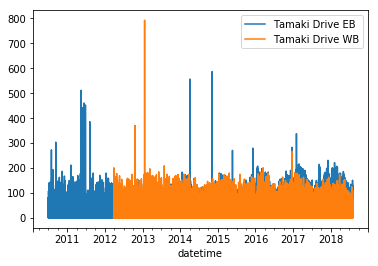

In [19]:
df.plot()

### adds Tamaki drive eastern bound and western bound together 

In [20]:
Tamaki = df.loc[:,'Tamaki Drive WB'] +  df.loc[:,'Tamaki Drive EB']

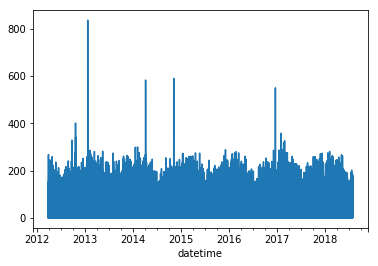

In [22]:
Tamaki.plot()

### restrict to the period where the hourly weather data is available 

In [23]:
Tamaki = Tamaki.loc['2013':'2018-06-01',]

In [24]:
Tamaki = Tamaki.to_frame(name='Tamaki Drive')

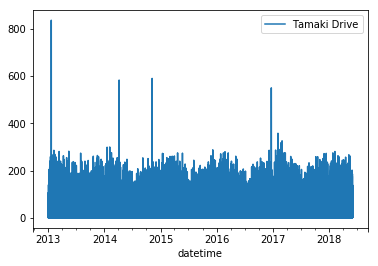

In [25]:
Tamaki.plot()

### plots the seasonal cycle 

In [32]:
seas_cycl = Tamaki.rolling(window=30*24, center=True).mean().groupby(Tamaki.index.dayofyear).mean()

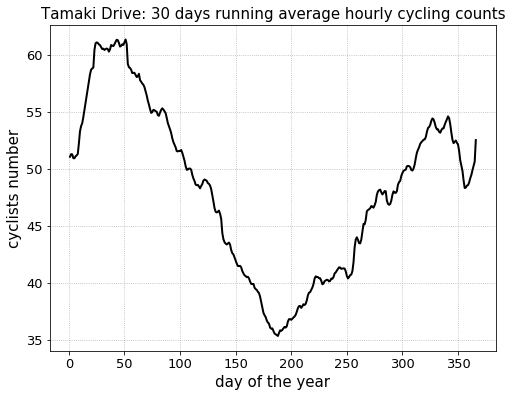

In [53]:
f, ax = plt.subplots(figsize=(8,6)) 

seas_cycl.plot(ax=ax, lw=2, color='k', legend=False)

ax.grid(ls=':')

ax.set_xlabel('day of the year', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Tamaki Drive: 30 days running average hourly cycling counts', fontsize=15)

f.savefig('../figures/paper/seasonal_cycle.png', dpi=200)
f.savefig('../figures/paper/seasonal_cycle.jpeg', dpi=200)
f.savefig('../figures/paper/seasonal_cycle.pdf')


### cyclists per day of week and hour of the day 

In [54]:
hour_week = Tamaki.copy()

In [55]:
hour_week.loc[:,'day_of_week'] = hour_week.index.dayofweek
hour_week.loc[:,'hour'] = hour_week.index.hour

In [56]:
hour_week = hour_week.groupby(['day_of_week','hour']).mean().unstack()

In [57]:
hour_week.columns = hour_week.columns.droplevel(0)

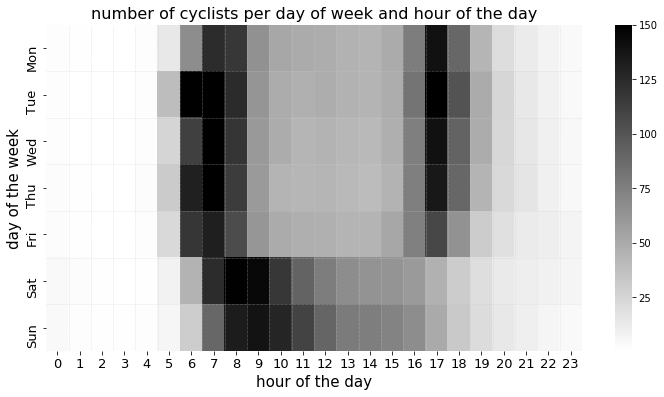

In [58]:
f, ax = plt.subplots(figsize=(12,6))
sns.heatmap(hour_week, ax = ax, cmap=plt.cm.gray_r, vmax=150)
# ax.grid(ls=':')
[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];
ax.set_title('number of cyclists per day of week and hour of the day', fontsize=16)
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
ax.set_xlabel('hour of the day', fontsize=15)
ax.set_ylabel('day of the week', fontsize=15)
ax.set_yticklabels(day_abbr[0:7]);
f.savefig('../figures/paper/cyclists_dayofweek_hourofday.png', dpi=200)
f.savefig('../figures/paper/cyclists_dayofweek_hourofday.jpeg', dpi=200)
f.savefig('../figures/paper/cyclists_dayofweek_hourofday.pdf')


In [59]:
summary_hour = Tamaki.groupby(Tamaki.index.hour).describe()

In [60]:
summary_hour.columns = summary_hour.columns.droplevel(0)

### looking at week days versus week-ends 

In [61]:
weekdays = Tamaki.loc[Tamaki.index.weekday_name.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]
weekends = Tamaki.loc[Tamaki.index.weekday_name.isin(['Sunday','Saturday'])]

In [62]:
summary_hour_weekdays = weekdays.groupby(weekdays.index.hour).describe()
summary_hour_weekends = weekends.groupby(weekends.index.hour).describe()

In [63]:
summary_hour_weekdays.columns = summary_hour_weekdays.columns.droplevel(0)

In [64]:
summary_hour_weekends.columns = summary_hour_weekends.columns.droplevel(0)

### black and white version

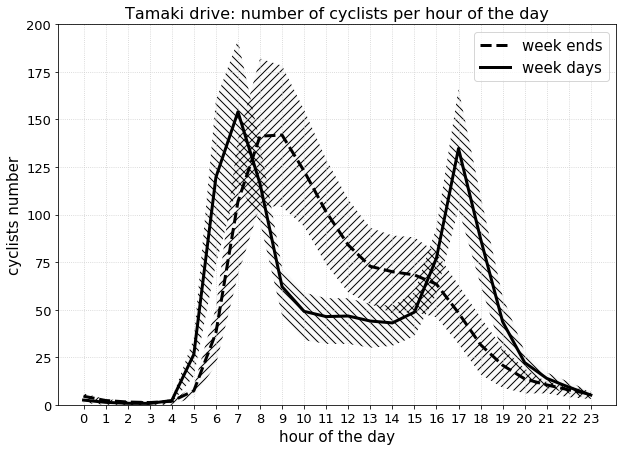

In [65]:
f, ax = plt.subplots(figsize=(10,7))

ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,'mean'], color='k', label='week ends', ls='--', lw=3)

ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,'25%'], \
                summary_hour_weekends.loc[:,'75%'], hatch='///', facecolor='0.8', alpha=0.1)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

# ax.set_title('week-ends', fontsize=16)

ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'mean'], color='k', label='week days', lw=3)

ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'25%'], \
                summary_hour_weekdays.loc[:,'75%'], hatch='\\\\\\', facecolor='0.8', alpha=0.1)

ax.legend(loc=1 , fontsize=15)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.set_ylim([0, 200])

ax.set_xlabel('hour of the day', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Tamaki drive: number of cyclists per hour of the day', fontsize=16)

f.savefig('../figures/paper/daily_cycle.png', dpi=200)
f.savefig('../figures/paper/daily_cycle.jpeg', dpi=200)
f.savefig('../figures/paper/daily_cycle.pdf')

### colour version

In [67]:
# f, ax = plt.subplots(figsize=(10,7))

# ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,'mean'], color='b', label='week ends')

# ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,'25%'], \
#                 summary_hour_weekends.loc[:,'75%'], color='steelblue', alpha=0.3)

# ax.set_xticks(range(24));

# ax.grid(ls=':', color='0.8')

# # ax.set_title('week-ends', fontsize=16)

# ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'mean'], color='r', label='week days')

# ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'25%'], \
#                 summary_hour_weekdays.loc[:,'75%'], color='coral', alpha=0.3)

# ax.legend(loc=1 , fontsize=15)

# ax.set_xticks(range(24));

# ax.grid(ls=':', color='0.8')

# ax.set_ylim([0, 200])

# ax.set_xlabel('hour of the day', fontsize=15)

# ax.set_ylabel('cyclists number', fontsize=15);

# [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
# [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

# ax.set_title('Tamaki drive: number of cyclists per hour of the day', fontsize=16)

# f.savefig('../figures/paper/daily_cycle.png', dpi=200)
# f.savefig('../figures/paper/daily_cycle.jpeg', dpi=200)
# f.savefig('../figures/paper/daily_cycle.pdf')


### getting rid of the outliers using a median filter 

In [68]:
def median_filter(df, varname = 'Tamaki Drive', window=24, std=3): 
    
    dfc = df.copy() 
    
    dfc = dfc.loc[:,[varname]]
    
    dfc['median']= dfc[varname].rolling(window, center=True).median()
    
    dfc['std'] = dfc[varname].rolling(window, center=True).std()
    
    dfc.loc[dfc.loc[:,varname] >= dfc['median']+std*dfc['std'], varname] = np.nan
    
    dfc.loc[dfc.loc[:,varname] <= dfc['median']-std*dfc['std'], varname] = np.nan
    
    return dfc.loc[:, varname]

In [69]:
dfc = Tamaki.copy()

In [70]:
dfc.loc[:,'Tamaki Drive, Filtered'] = median_filter(dfc)

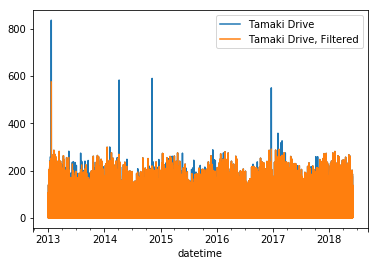

In [71]:
dfc.plot()

In [72]:
df_filtered = dfc.loc[:,['Tamaki Drive, Filtered']].resample('1D').sum()

In [73]:
data = df_filtered.loc['2013':,['Tamaki Drive, Filtered']]

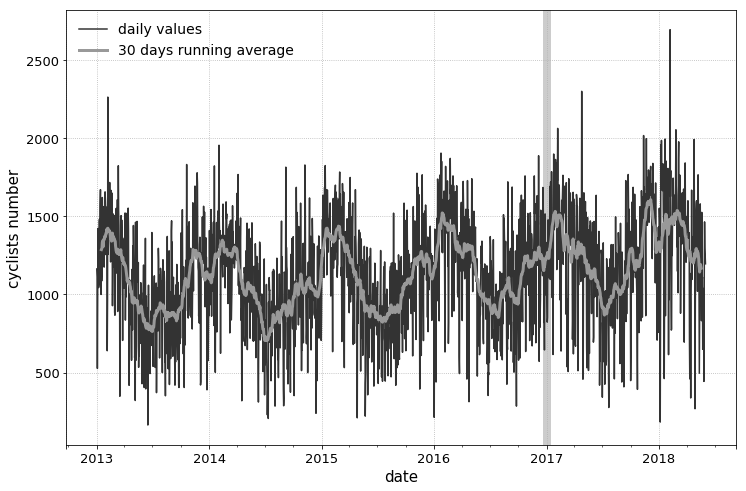

In [74]:
f, ax = plt.subplots(figsize=(12,8))

data.plot(ax=ax, color='0.2')

data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3, color='0.6')

ax.grid(ls=':')
ax.legend(['daily values','30 days running average'], frameon=False, fontsize=14)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

ax.axvline('2017', color='0.8', lw=8, zorder=-1)

f.savefig('../figures/paper/cycling_counts_Tamaki_drive.png', dpi=200)
f.savefig('../figures/paper/cycling_counts_Tamaki_drive.jpeg', dpi=200)
f.savefig('../figures/paper/cycling_counts_Tamaki_drive.pdf', dpi=200)

### prepares the data for ingesting in fbprophet

In [75]:
data = data.rename({'Tamaki Drive, Filtered':'y'}, axis=1)

In [76]:
data.head()

,y
datetime,
2013-01-01,1163.0
2013-01-02,1112.0
2013-01-03,527.0
2013-01-04,1045.0
2013-01-05,1422.0


In [77]:
def add_regressor(data, regressor, varname=None): 
    
    """
    adds a regressor to a dataframe of targets
    """
    
    data_with_regressors = data.copy()
    
    data_with_regressors.loc[:,varname] = regressor.loc[:,varname]
    
    return data_with_regressors

In [78]:
def prepare_data(data, year=2017): 
    
    """
    prepare the data for ingestion by fbprophet: 
    
    1) divide in training and test set, using the `year` parameter (int)
    
    2) reset the index and rename the `datetime` column to `ds`
    
    returns the training and test dataframes
    """
    
    
    data_train = data.loc[:str(year - 1),:]
    
    data_test = data.loc[str(year):,:]
    
    data_train.reset_index(inplace=True)
    
    data_test.reset_index(inplace=True)
    
    data_train = data_train.rename({'datetime':'ds'}, axis=1)
    
    data_test = data_test.rename({'datetime':'ds'}, axis=1)
    
    return data_train, data_test

In [79]:
def make_verif(forecast, data_train, data_test): 
    """
    put together the forecast (coming from fbprophet) 
    and the overved data, and set the index to be a proper datetime index, 
    for plotting
    
    """
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [80]:
def plot_verif(verif, year=2017):
    """
    plots the forecasts and observed data, the year parameters is used to indicate 
    the division between the training and test sets 
    """
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

In [81]:
def plot_verif_component(verif, component='rain', year=2017): 
    """
    plots a specific component of the model
    """
    
    f, ax = plt.subplots(figsize=(10, 8))
    
    train = verif.loc[:str(year - 1),:]
        
    ax.plot(train.index, train.loc[:,component] * 100, color='steelblue', lw=1)
    
    ax.fill_between(train.index, train.loc[:, component+'_lower'] * 100, train.loc[:, component+'_upper'] * 100, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
        
    ax.plot(test.index, test.loc[:,component] * 100, color='coral', lw=1)
    
    ax.fill_between(test.index, test.loc[:, component+'_lower'] * 100, test.loc[:, component+'_upper'] * 100, color='coral', alpha=0.3)
    
    ax.axvline(str(year), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

In [82]:
def add_regressor_to_future(future, regressors_list): 
    """
    adds extra regressors to a `future` dataframe created by fbprophet
    """
    
    futures = future.copy() 
    
    futures.index = pd.to_datetime(futures.ds)
    
    regressors = pd.concat(regressors_list, axis=1)
    
    futures = futures.merge(regressors, left_index=True, right_index=True)
    
    futures = futures.reset_index(drop = True) 
    
    return futures

### splits the data into a training and test set, and returns these data frames in a format **fbprophet** can understand 

In [83]:
data_train, data_test = prepare_data(data, 2017)

### instantiates, then fit the model to the training data 

The first step in **fbprophet** is to instantiate the model, it is there that you can set the `prior scales` for each component of your time-series, as well as the number of Fourier series to use to model the cyclic components.   

A general rule is that larger prior scales and larger number of Fourier series will make the model more flexible, but at the potential cost of generalisation: i.e. the model might [overfit](https://en.wikipedia.org/wiki/Overfitting), learning the noise (rather than the signal) in the training data, but 
    giving poor results when applied to yet unseen data (the test data)... setting these [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) can be more an art than a science ... 

In [84]:
m = Prophet(mcmc_samples=300, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [85]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


### make the `future` dataframe 

In [86]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [87]:
future.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [88]:
future.tail()

,ds
1973,2018-05-28
1974,2018-05-29
1975,2018-05-30
1976,2018-05-31
1977,2018-06-01


### forecast

In [89]:
forecast = m.predict(future)

### plots the `components` of the forecast (trend + cyclic component [yearly seasonality, weekly seasonality] at this stage)

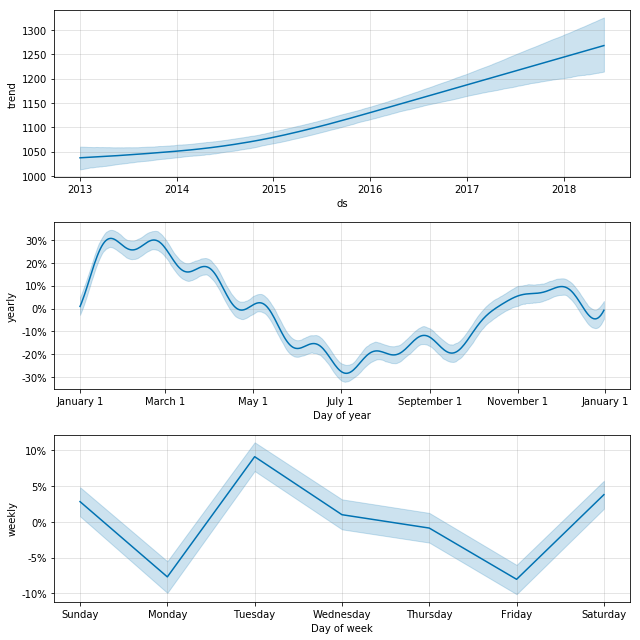

In [90]:
f = m.plot_components(forecast)

### put it all together with the actual observations 

In [91]:
verif = make_verif(forecast, data_train, data_test)

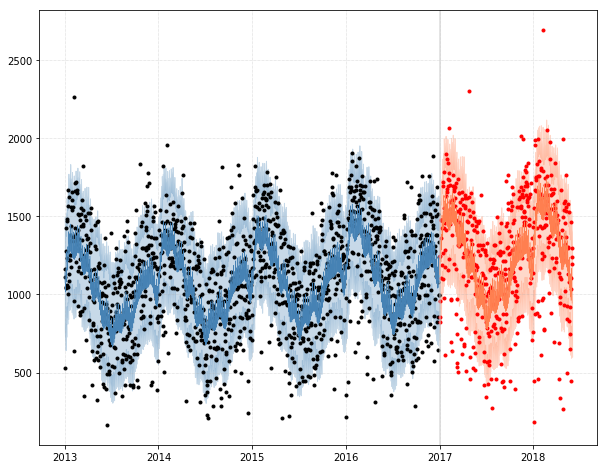

In [92]:
f = plot_verif(verif)

### scatter plot, marginal distribution and correlation between observations and modelled / predicted values 

#### training set 

In [114]:
def plot_joint_plot(verif, x='yhat', y='y', title=None, fpath = '../figures/paper', fname = None): 
    
    g = sns.JointGrid(x='yhat', y='y', data = verif)
    g = g.plot(sns.regplot, sns.distplot)
    g.fig.set_figwidth(6)
    g.fig.set_figheight(6)

    ax = g.fig.axes[1]
    
    if title is not None: 
        ax.set_title(title, fontsize=16)

    ax = g.fig.axes[0]

    ax.set_xlim([-5, None])
    ax.set_ylim([-5, None])

    ax.text(100, 2000, "R = {:+4.2f}\nMAE = {:4.1f}".format(verif.loc[:,['y','yhat']].corr().iloc[0,1], MAE(verif.loc[:,'y'].values, verif.loc[:,'yhat'].values)), fontsize=16)

    ax.set_xlabel("model's estimate", fontsize=15)
    
    ax.set_ylabel("observation", fontsize=15)
    
    ax.grid(ls=':')

    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')
    
    if fname is not None: 
        for ext in ['png','jpeg','pdf']: 
            g.fig.savefig(os.path.join(fpath, "{}.{}".format(fname, ext)), dpi=200)

#### train set 

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


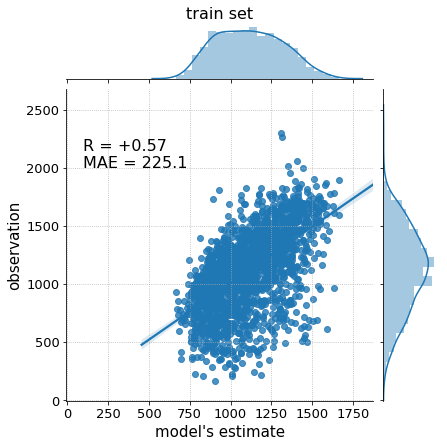

In [116]:
plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_no_climate')

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


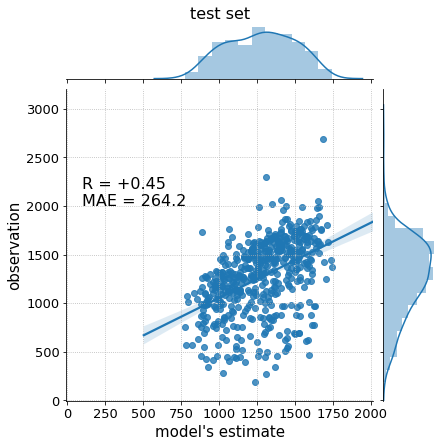

In [117]:
plot_joint_plot(verif.loc['2017':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [118]:
verif.loc['2017':,['y','yhat']].corr()

,y,yhat
y,1.00000,0.45179
yhat,0.45179,1.00000


### Mean Absolute Error (in number of cyclists)

In [119]:
MAE(verif.y.values, verif.yhat.values)

229.4938084920356

## now incorporating the effects of the holidays 

In [120]:
holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

In [121]:
ldates = []
lnames = []
for date, name in sorted(holidays.NZ(prov='AUK', years=np.arange(2013, 2018 + 1)).items()):
#     print(date, name)
    ldates.append(date)
    lnames.append(name)

In [122]:
ldates = np.array(ldates)
lnames = np.array(lnames)

In [123]:
holidays_df.loc[:,'ds'] = ldates

In [124]:
holidays_df.loc[:,'holiday'] = lnames

In [125]:
holidays_df.tail()

,ds,holiday
67,2018-04-25,Anzac Day
68,2018-06-04,Queen's Birthday
69,2018-10-22,Labour Day
70,2018-12-25,Christmas Day
71,2018-12-26,Boxing Day


In [126]:
holidays_df.holiday.unique()

array(["New Year's Day", "Day after New Year's Day",
       'Auckland Anniversary Day', 'Waitangi Day', 'Good Friday',
       'Easter Monday', 'Anzac Day', "Queen's Birthday", 'Labour Day',
       'Christmas Day', 'Boxing Day', 'Anzac Day (Observed)',
       'Boxing Day (Observed)', "Day after New Year's Day (Observed)",
       'Waitangi Day (Observed)', 'Christmas Day (Observed)',
       "New Year's Day (Observed)"], dtype=object)

In [127]:
def remove_obs(x): 
    return x.replace(' (Observed)','')

In [128]:
holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(remove_obs)

In [129]:
# holidays_df.loc[:,'lower_window'] = -1 
# holidays_df.loc[:,'upper_window'] = 1 


In [130]:
# holidays_df.loc[holidays_df.holiday == 'Christmas Day','lower_window'] = -3

In [131]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [132]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/fbprophet/forecaster.py:253: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  df = df.sort_values('ds')
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [133]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [134]:
forecast = m.predict(future)

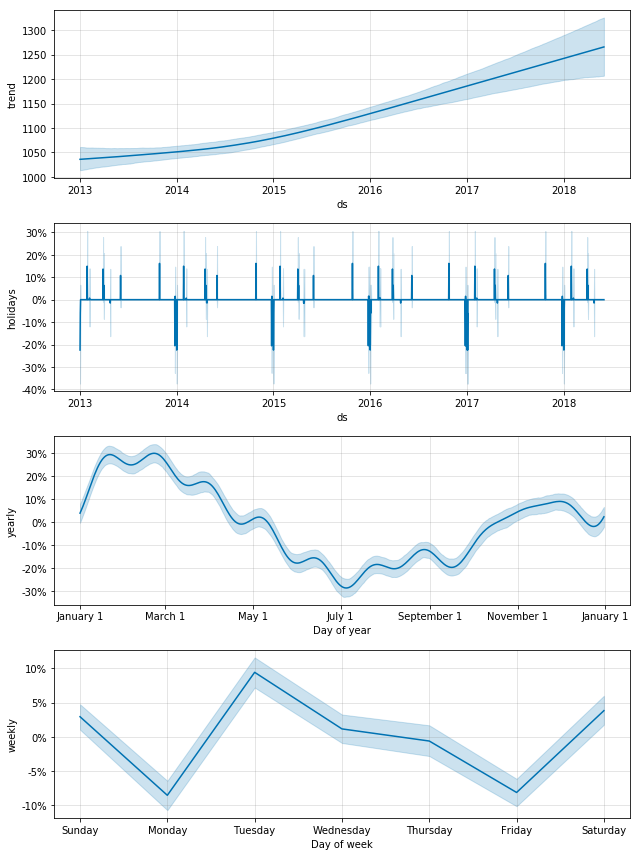

In [135]:
f = m.plot_components(forecast)

In [136]:
verif = make_verif(forecast, data_train, data_test)

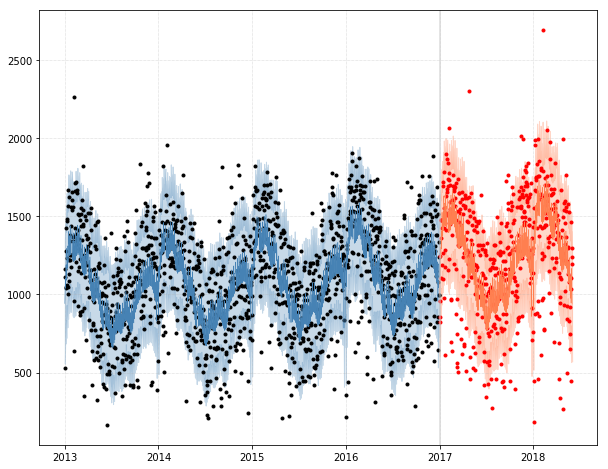

In [137]:
f = plot_verif(verif)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


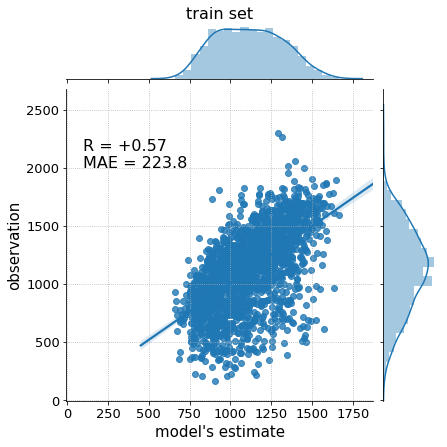

In [138]:
plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_no_climate_holidays')

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


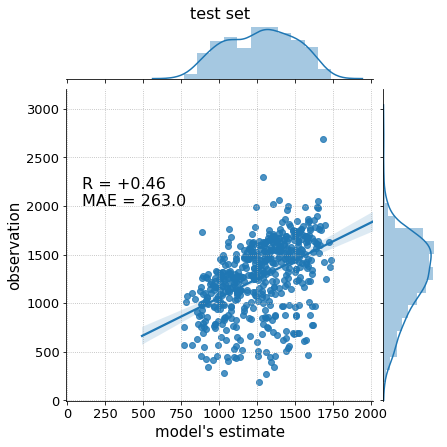

In [139]:
plot_joint_plot(verif.loc['2017':,:], title='test set', fname='test_set_joint_plot_no_climate_holidays')

In [140]:
(verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']).mean()

7.179789323395584

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


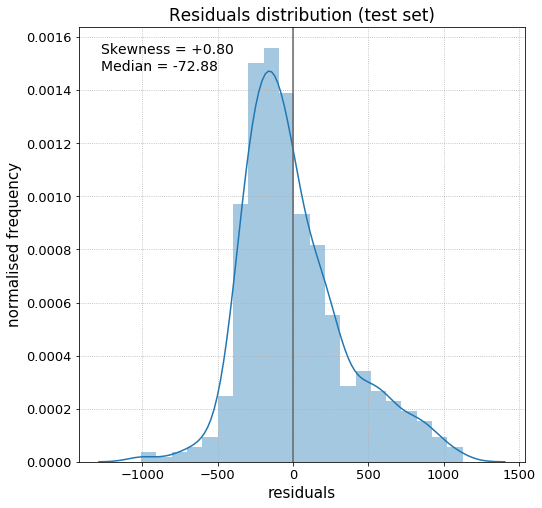

In [141]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot((verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']), ax=ax)
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']), (verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

f.savefig('../figures/paper/residuals_distribution_test_set_no_climate.jpeg', dpi=200)
f.savefig('../figures/paper/residuals_distribution_test_set_no_climate.pdf')

## incorporating the effects of weather conditions

#### temperature 

In [142]:
temp = pd.read_csv('../data/weather/hourly/commute/temp_day.csv', index_col=0, parse_dates=True)

In [143]:
temp = temp.loc[:,['Tmin(C)']]

In [144]:
temp.columns = ['temp']

In [145]:
temp.head()

,temp
2012-01-01,19.807143
2012-01-02,18.000000
2012-01-03,19.335714
2012-01-04,19.307143
2012-01-05,19.978571


#### rainfall 

In [146]:
rain = pd.read_csv('../data/weather/hourly/commute/rain_day.csv', index_col=0, parse_dates=True)

In [147]:
rain = rain.loc[:,['Amount(mm)']]

In [148]:
rain.columns = ['rain']

In [149]:
rain.head()

,rain
2012-01-01,0.000000
2012-01-02,0.000000
2012-01-03,0.028571
2012-01-04,0.185714
2012-01-05,0.014286


#### sunshine fraction 

In [150]:
sun = pd.read_csv('../data/weather/hourly/commute/sun_day.csv', index_col=0, parse_dates=True)

In [151]:
sun.columns = ['sun']

In [152]:
sun.head()

,sun
2012-01-01,0.078571
2012-01-02,0.128571
2012-01-03,0.321429
2012-01-04,0.128571
2012-01-05,0.378571


#### wind 

In [153]:
wind = pd.read_csv('../data/weather/hourly/commute/wind_day.csv', index_col=0, parse_dates=True)

In [154]:
wind = wind.loc[:,['Speed(m/s)']]

In [155]:
wind.columns = ['wind']

In [156]:
wind.head()

,wind
2011-01-01,8.464286
2011-01-02,3.857143
2011-01-03,3.871429
2011-01-04,2.392857
2011-01-05,6.621429


### restrict to the available period 

In [157]:
temp = temp.loc['2013':'2018-06-01',:]

In [158]:
rain = rain.loc['2013':'2018-06-01',:]

In [159]:
sun = sun.loc['2013':'2018-06-01',:]

In [160]:
wind = wind.loc['2013':'2018-06-01',:]

### interpolate so that there are no missing values 

In [161]:
temp = temp.interpolate(method='linear')

In [162]:
rain = rain.interpolate(method='linear')

In [163]:
sun = sun.interpolate(method='linear')

In [164]:
wind = wind.interpolate(method='linear')

### adds the climate regressors to the data 

In [165]:
data_with_regressors = add_regressor(data, temp, varname='temp')

In [166]:
data_with_regressors = add_regressor(data_with_regressors, rain, varname='rain')

In [167]:
data_with_regressors = add_regressor(data_with_regressors, sun, varname='sun')

In [168]:
data_with_regressors = add_regressor(data_with_regressors, wind, varname='wind')

In [169]:
data_with_regressors.head()

,y,temp,rain,sun,wind
datetime,,,,,
2013-01-01,1163.0,20.000000,0.000000,0.950000,6.100000
2013-01-02,1112.0,20.342857,0.000000,0.535714,4.428571
2013-01-03,527.0,16.278571,0.228571,0.014286,4.728571
2013-01-04,1045.0,17.635714,0.000000,0.742857,8.978571
2013-01-05,1422.0,19.592857,0.000000,0.964286,6.185714


In [170]:
data_with_regressors.tail()

,y,temp,rain,sun,wind
datetime,,,,,
2018-05-28,1107.0,8.750000,0.0,0.271429,3.200000
2018-05-29,1464.0,7.764286,0.0,0.671429,2.571429
2018-05-30,1298.0,7.614286,0.0,0.621429,2.378571
2018-05-31,1239.0,8.192857,0.0,0.678571,2.057143
2018-06-01,1196.0,9.085714,0.0,0.635714,2.178571


### prepare the data and subsets (train and test set)

In [171]:
data_train, data_test = prepare_data(data_with_regressors, 2017)

In [172]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [173]:
m.add_regressor('temp', prior_scale=0.5, mode='multiplicative')
m.add_regressor('rain', prior_scale=0.5, mode='multiplicative')
m.add_regressor('sun', prior_scale=0.5, mode='multiplicative')
m.add_regressor('wind', prior_scale=0.5, mode='multiplicative')

In [174]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


In [175]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [176]:
futures = add_regressor_to_future(future, [temp, rain, sun, wind])

In [177]:
futures.head()

,ds,temp,rain,sun,wind
0,2013-01-01,20.000000,0.000000,0.950000,6.100000
1,2013-01-02,20.342857,0.000000,0.535714,4.428571
2,2013-01-03,16.278571,0.228571,0.014286,4.728571
3,2013-01-04,17.635714,0.000000,0.742857,8.978571
4,2013-01-05,19.592857,0.000000,0.964286,6.185714


In [178]:
forecast = m.predict(futures)

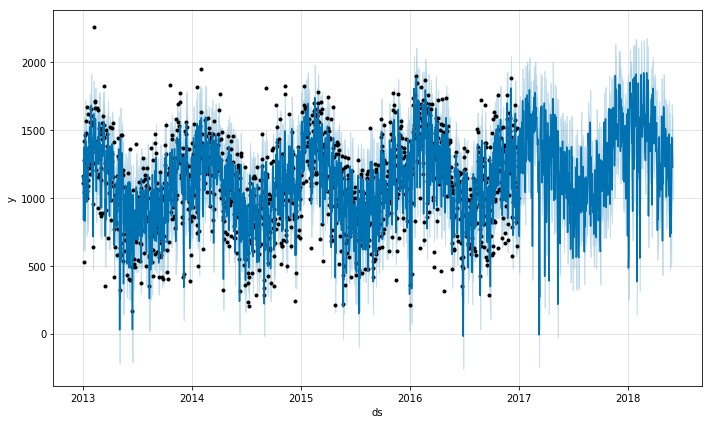

In [179]:
f = m.plot(forecast)

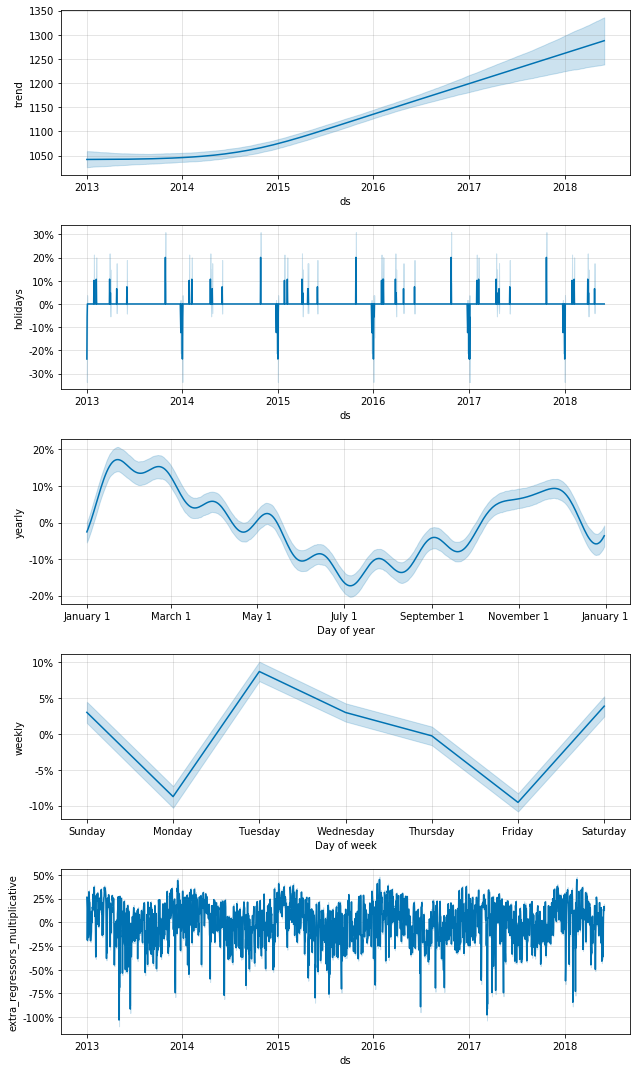

In [180]:
f = m.plot_components(forecast)

In [183]:
verif = make_verif(forecast, data_train, data_test)

In [184]:
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Anzac Day,Anzac Day_lower,Anzac Day_upper,Auckland Anniversary Day,...,wind_lower,wind_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2013-01-01,1041.870468,883.327932,1390.155534,1025.760014,1059.051760,0.0,0.0,0.0,0.0,...,-0.047363,-0.041287,-0.025645,-0.054588,0.001686,0.0,0.0,0.0,1133.253872,1163.0
2013-01-02,2013-01-02,1041.872458,895.969635,1409.608921,1025.818207,1059.033024,0.0,0.0,0.0,0.0,...,0.023503,0.026962,-0.015900,-0.044848,0.010665,0.0,0.0,0.0,1160.647475,1112.0
2013-01-03,2013-01-03,1041.874449,610.637234,1056.721687,1025.829901,1059.013219,0.0,0.0,0.0,0.0,...,0.011874,0.013621,-0.005174,-0.033371,0.022216,0.0,0.0,0.0,837.686704,527.0
2013-01-04,2013-01-04,1041.876439,737.240803,1198.561396,1025.860488,1058.999817,0.0,0.0,0.0,0.0,...,-0.175366,-0.152871,0.006391,-0.022085,0.035047,0.0,0.0,0.0,973.872633,1045.0
2013-01-05,2013-01-05,1041.878430,1140.231566,1603.682179,1025.896039,1058.995654,0.0,0.0,0.0,0.0,...,-0.051174,-0.044610,0.018633,-0.009446,0.048494,0.0,0.0,0.0,1374.013426,1422.0


### clips the forecasts so that no value is negative (can't have a negative number of cyclists ! )

In [185]:
verif.loc[:,'yhat'] = verif.yhat.clip_lower(0)

In [186]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip_lower(0)

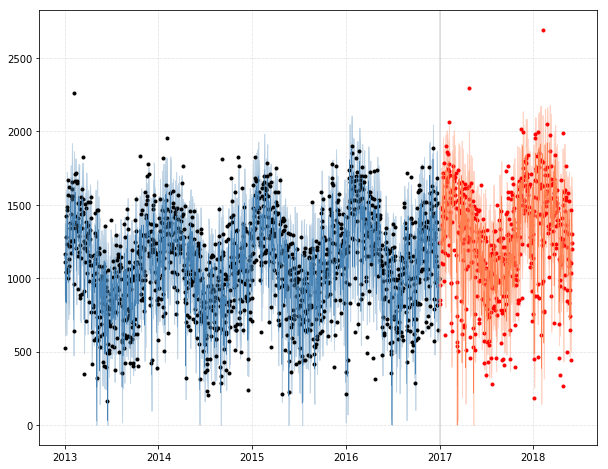

In [187]:
f =  plot_verif(verif)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


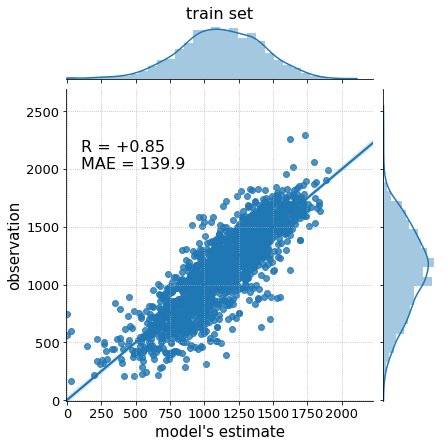

In [188]:
plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_climate')

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


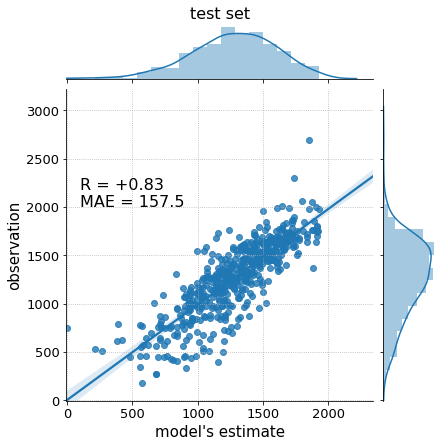

In [189]:
plot_joint_plot(verif.loc['2017':,:], title='test set', fname='test_set_joint_plot_no_climate')

### residuals distributions (test set)

In [190]:
residuals = verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


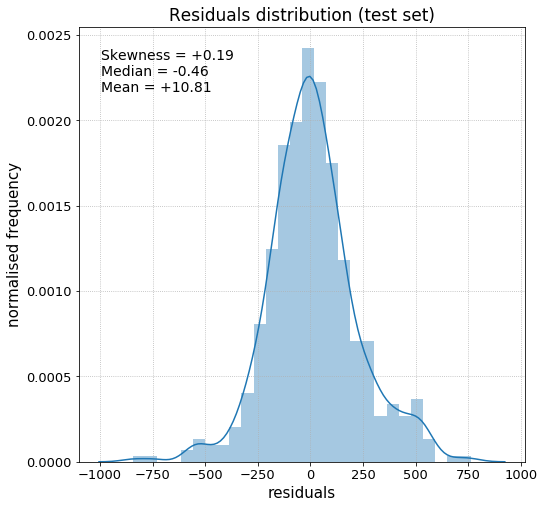

In [191]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals, ax=ax)
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals), residuals.median(), residuals.mean()), \
        fontsize=14, transform=ax.transAxes)

f.savefig('../figures/paper/residuals_distribution_test_set_climate.png', dpi=200)
f.savefig('../figures/paper/residuals_distribution_test_set_climate.jpeg', dpi=200)
f.savefig('../figures/paper/residuals_distribution_test_set_climate.pdf')

### plots the forecasts (`yhat`, orange line) and the observed values (`y`, blue line) for the first 8 months of 2017

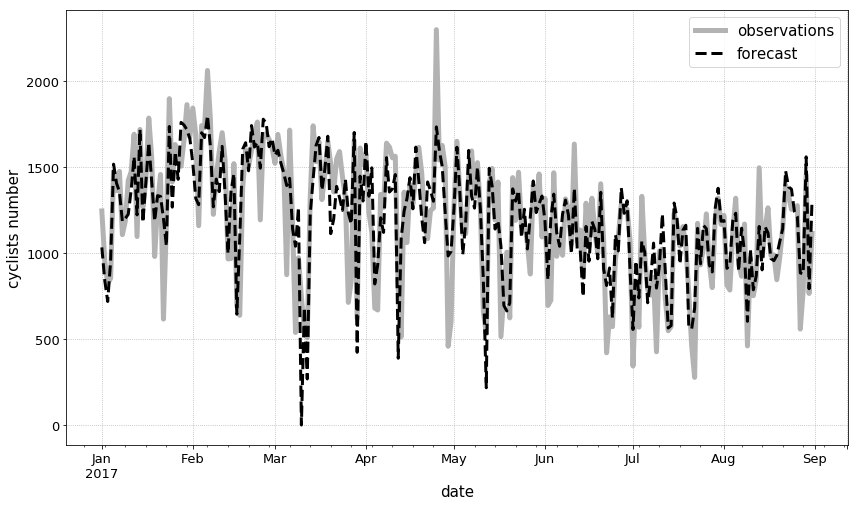

In [199]:
f, ax = plt.subplots(figsize=(14,8))

verif.loc['2017-01-01':'2017-08-31',['y']].plot(lw=5, ax=ax, color='0.7', ls='-')

verif.loc['2017-01-01':'2017-08-31',['yhat']].plot(lw=3, ax=ax, color='k', ls='--')


ax.grid(ls=':')
ax.legend(['observations','forecast'], fontsize=15)
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
ax.set_ylabel('cyclists number', fontsize=15)
ax.set_xlabel('date', fontsize=15)

for ext in ['png','jpeg','pdf']: 
    f.savefig('../figures/paper/forecasts_obs_2017-08.{}'.format(ext), dpi=200)

### running correlations (over 90 days) between observed and modelled / predicted values, useful to identify when things go South

In [201]:
corr = verif.loc[:,['y','yhat']].rolling(window=90, center=True).corr().iloc[0::2,1]

In [202]:
corr.index = corr.index.droplevel(1)

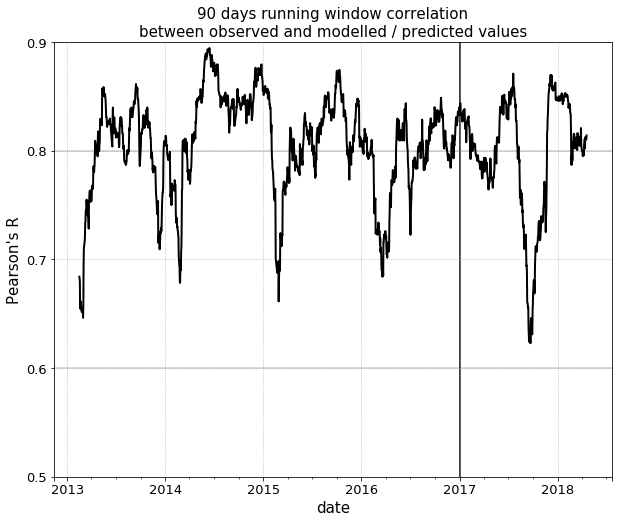

In [203]:
f, ax = plt.subplots(figsize=(10, 8))
corr.plot(ax=ax, lw=2, color='k')
ax.axhline(0.8, color='0.8', zorder=-1)
ax.axhline(0.6, color='0.8', zorder=-1)
ax.axvline('2017', color='k', zorder=-1)
ax.grid(ls=':')
ax.set_ylim([0.5, 0.9])
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_yticks(np.arange(0.5, 1., 0.1)); 

ax.set_title('90 days running window correlation\nbetween observed and modelled / predicted values', fontsize=15)

f.savefig('../figures/paper/moving_corr.png', dpi=200)
f.savefig('../figures/paper/moving_corr.jpeg', dpi=200)
f.savefig('../figures/paper/moving_corr.pdf')

### correlation grouped by month, is there seasonality in the performance of the model ?

In [204]:
corr_season_test = verif.loc['2017':,['y','yhat']].groupby(verif.loc['2017':,:].index.month).corr()
corr_season_train = verif.loc[:'2017',['y','yhat']].groupby(verif.loc[:'2017',:].index.month).corr()
corr_season = verif.loc[:,['y','yhat']].groupby(verif.loc[:,:].index.month).corr()

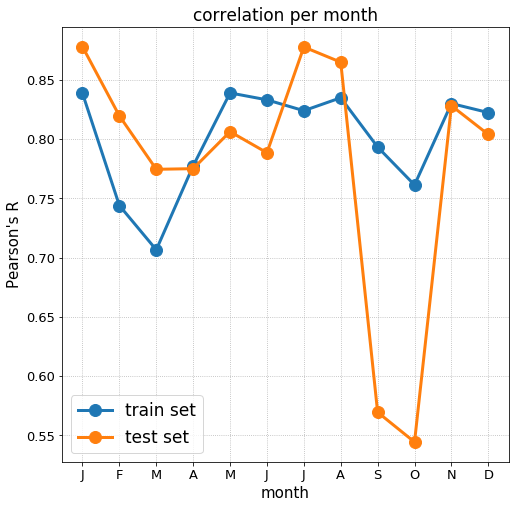

In [205]:
f, ax = plt.subplots(figsize=(8,8))
corr_season_train.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='train set')
corr_season_test.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='test set')
# corr_season.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12)

ax.legend(fontsize=17, loc=3)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(list('JFMAMJJASOND'))
ax.set_xlabel('month', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('correlation per month', fontsize=17)

f.savefig('../figures/paper/correlation_obs_pred_per_month.png', dpi=200)
f.savefig('../figures/paper/correlation_obs_pred_per_month.jpeg', dpi=200)
f.savefig('../figures/paper/correlation_obs_pred_per_month.pdf')

### plot the contribution of the different climate variables to the response variable (in percentage of the trend component, as we chose a multiplicative model)

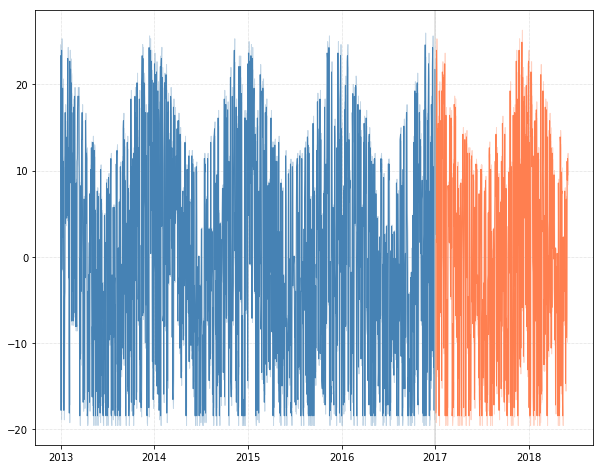

In [206]:
f  = plot_verif_component(verif, component = 'sun')

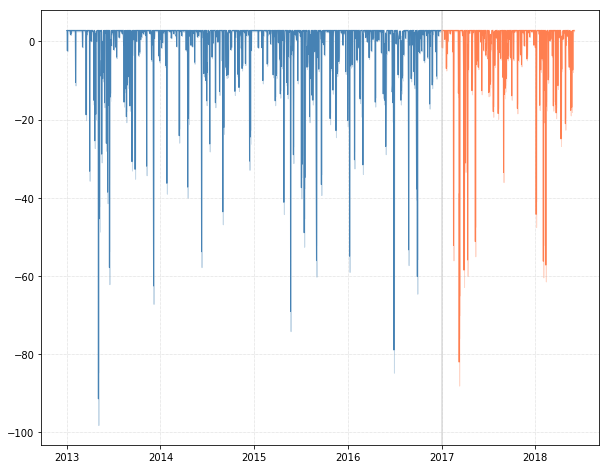

In [207]:
f  = plot_verif_component(verif, component = 'rain')

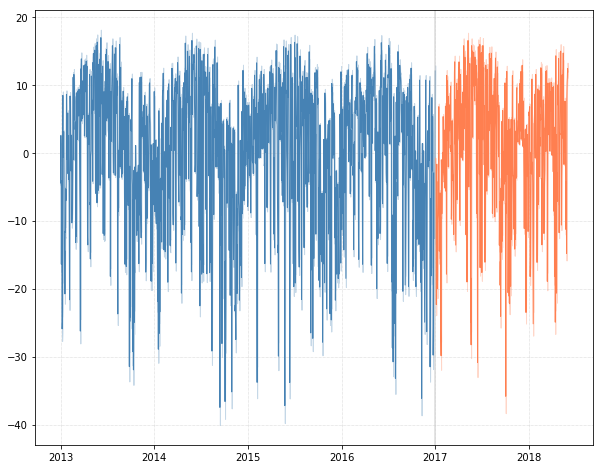

In [208]:
f  = plot_verif_component(verif, component = 'wind')

### plots the combined contribution of the climate extra-regressors

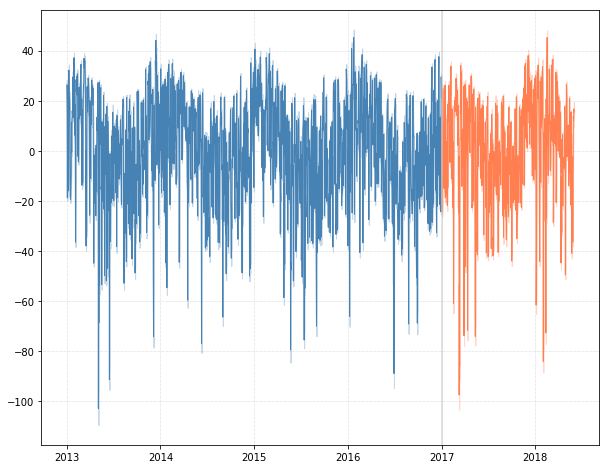

In [209]:
f = plot_verif_component(verif, component = 'extra_regressors_multiplicative')

### zoom in on the post 2016 period (test set)

In [210]:
verif.loc['2016-12-31':,'extra_regressors_multiplicative'].abs().mean()

0.1640455183310634

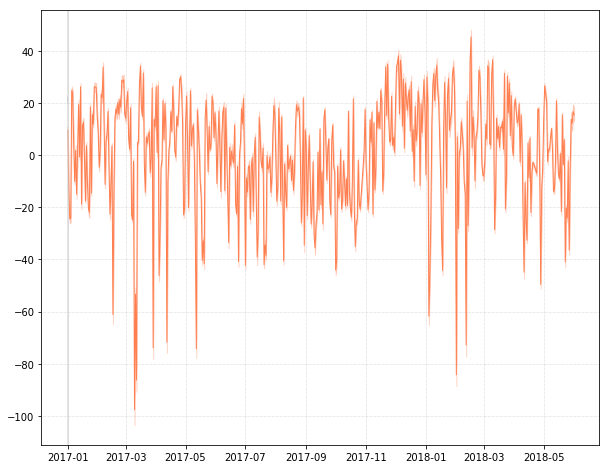

In [211]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'extra_regressors_multiplicative')

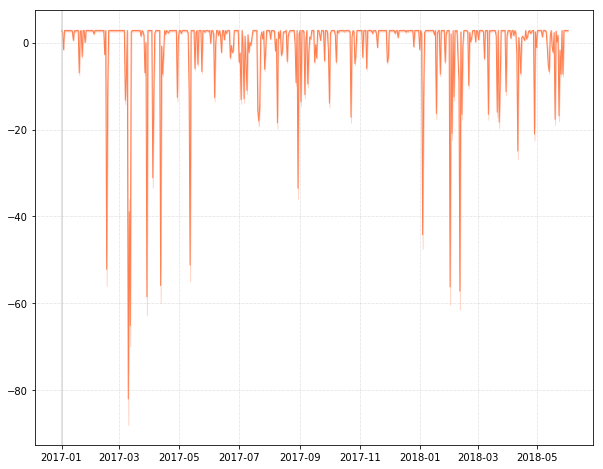

In [212]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'rain')

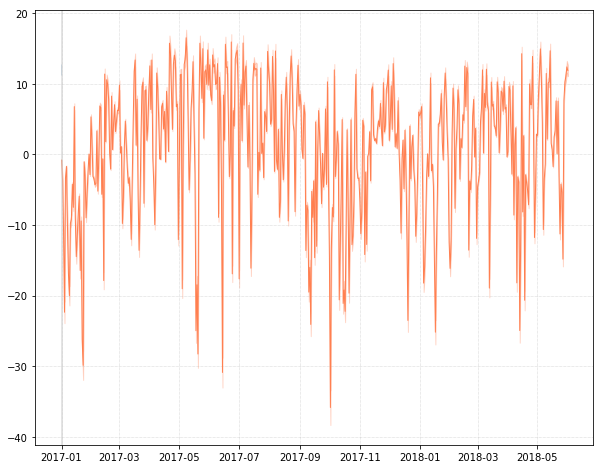

In [213]:
f = plot_verif_component(verif.loc['2016-12-31':,:], component = 'wind')